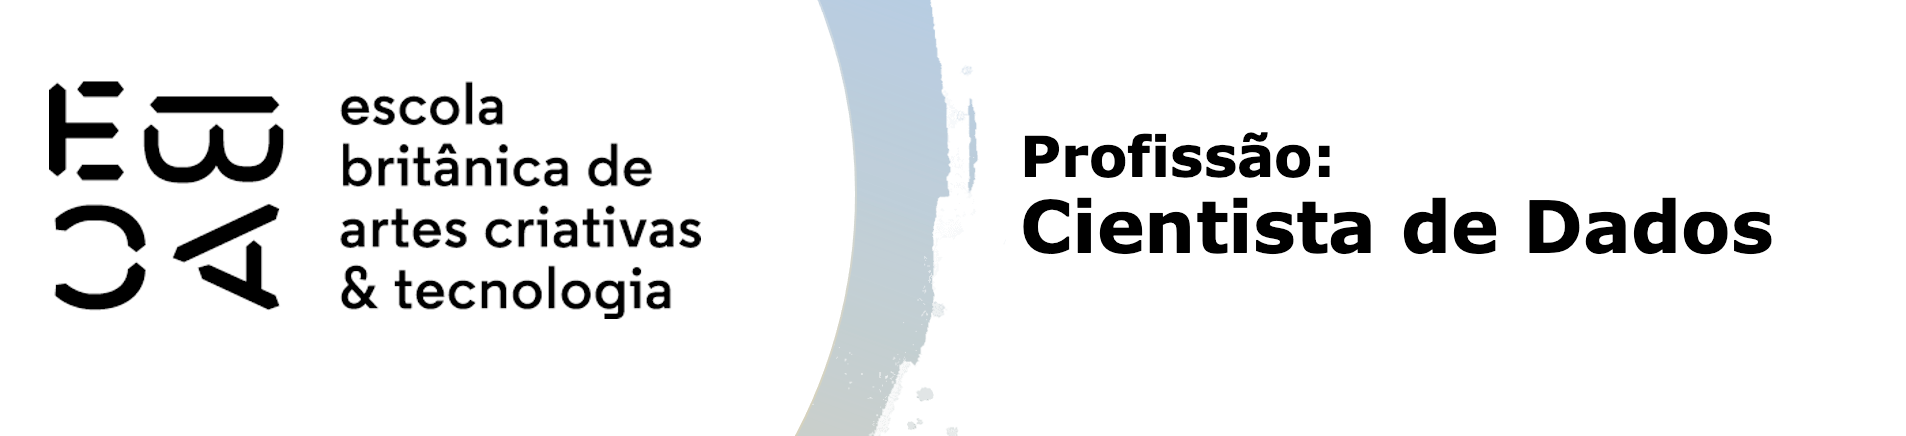

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
import warnings 

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
warnings.filterwarnings('ignore')

df = pd.read_feather('./credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [2]:
df['mau'] = df.mau.astype('bool')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [4]:
df1 = df.copy()

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
desenvolvimento = df[(df['data_ref']<'2015-12-01')].copy()
desenvolvimento

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,2015-11-01,2107,F,S,S,0,Empresário,Superior completo,Casado,Casa,27,4.676712,2.0,9766.79,False
549996,2015-11-01,3100,F,S,S,0,Empresário,Superior completo,Casado,Casa,54,15.558904,2.0,55288.72,False
549997,2015-11-01,14692,F,N,N,0,Pensionista,Médio,Solteiro,Casa,63,NaN,1.0,8711.06,False
549998,2015-11-01,2990,M,S,S,0,Assalariado,Superior completo,Casado,Casa,29,1.128767,2.0,51248.02,False


In [7]:
out_of_time = df[(df['data_ref']>'2015-12-01')].copy()
out_of_time

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [9]:
df['Mes'] = df['data_ref'].dt.month

In [10]:
df['Mes'].value_counts()

Mes
1     100000
2     100000
3     100000
4      50000
5      50000
6      50000
7      50000
8      50000
9      50000
10     50000
11     50000
12     50000
Name: count, dtype: int64

<Axes: xlabel='Mes', ylabel='Count'>

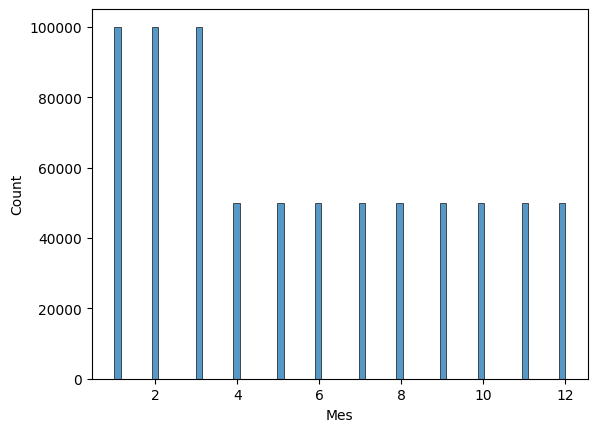

In [11]:
#univariada
sns.histplot(data=df, x="Mes")

<Axes: xlabel='mau', ylabel='Count'>

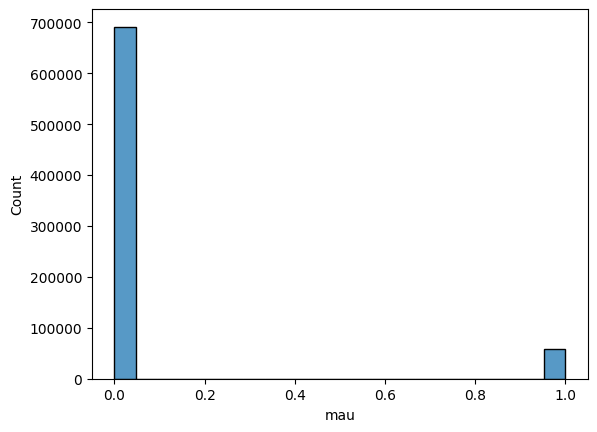

In [12]:
#univariada
sns.histplot(data=df, x="mau")

<Axes: xlabel='mau', ylabel='Count'>

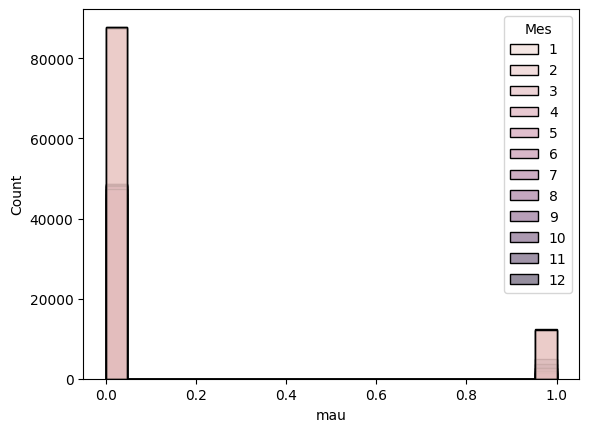

In [13]:
#univariada
sns.histplot(data=df, x="mau",hue='Mes')

<Axes: xlabel='tempo_emprego', ylabel='Count'>

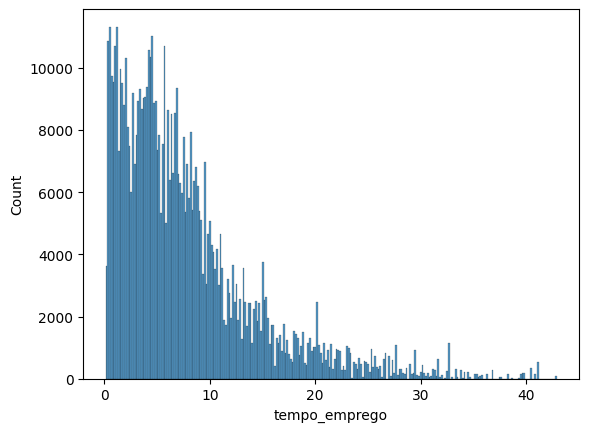

In [14]:
#univariada
sns.histplot(data=df, x="tempo_emprego")

<Axes: xlabel='idade'>

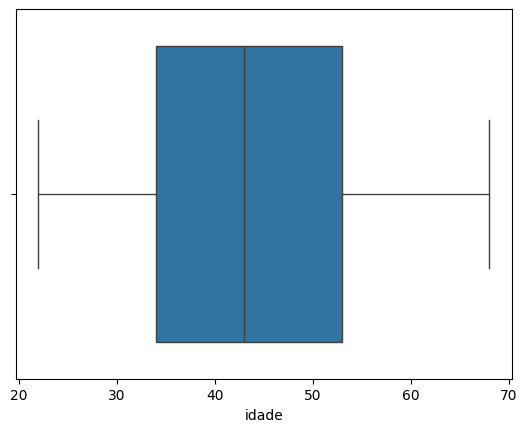

In [15]:
#univariada
sns.boxplot(data=df, x="idade")

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [17]:
variaveis = ['sexo','posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'Mes']

<Axes: xlabel='renda', ylabel='tempo_emprego'>

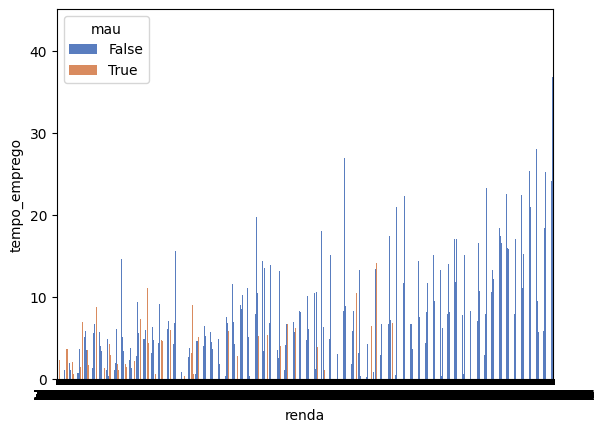

In [18]:
#bivariada
sns.barplot(x="renda", y="tempo_emprego", hue="mau", ci=None, palette="muted", data=df)

<font color='red'>Observação: Apesar do grafico ter ficado de dificil precisao ao analisar a renda, sabemos que o crescimentoda renda é da esquerda para a direita, sendo assim, conseguimos afirmar que a maioria das pessoas que se tornaram 'maus' possuem um tempo de emprego inferior a 10 e a medida que a renda aumenta tambem diminui a frequencia de retornos como 'mau'<font>

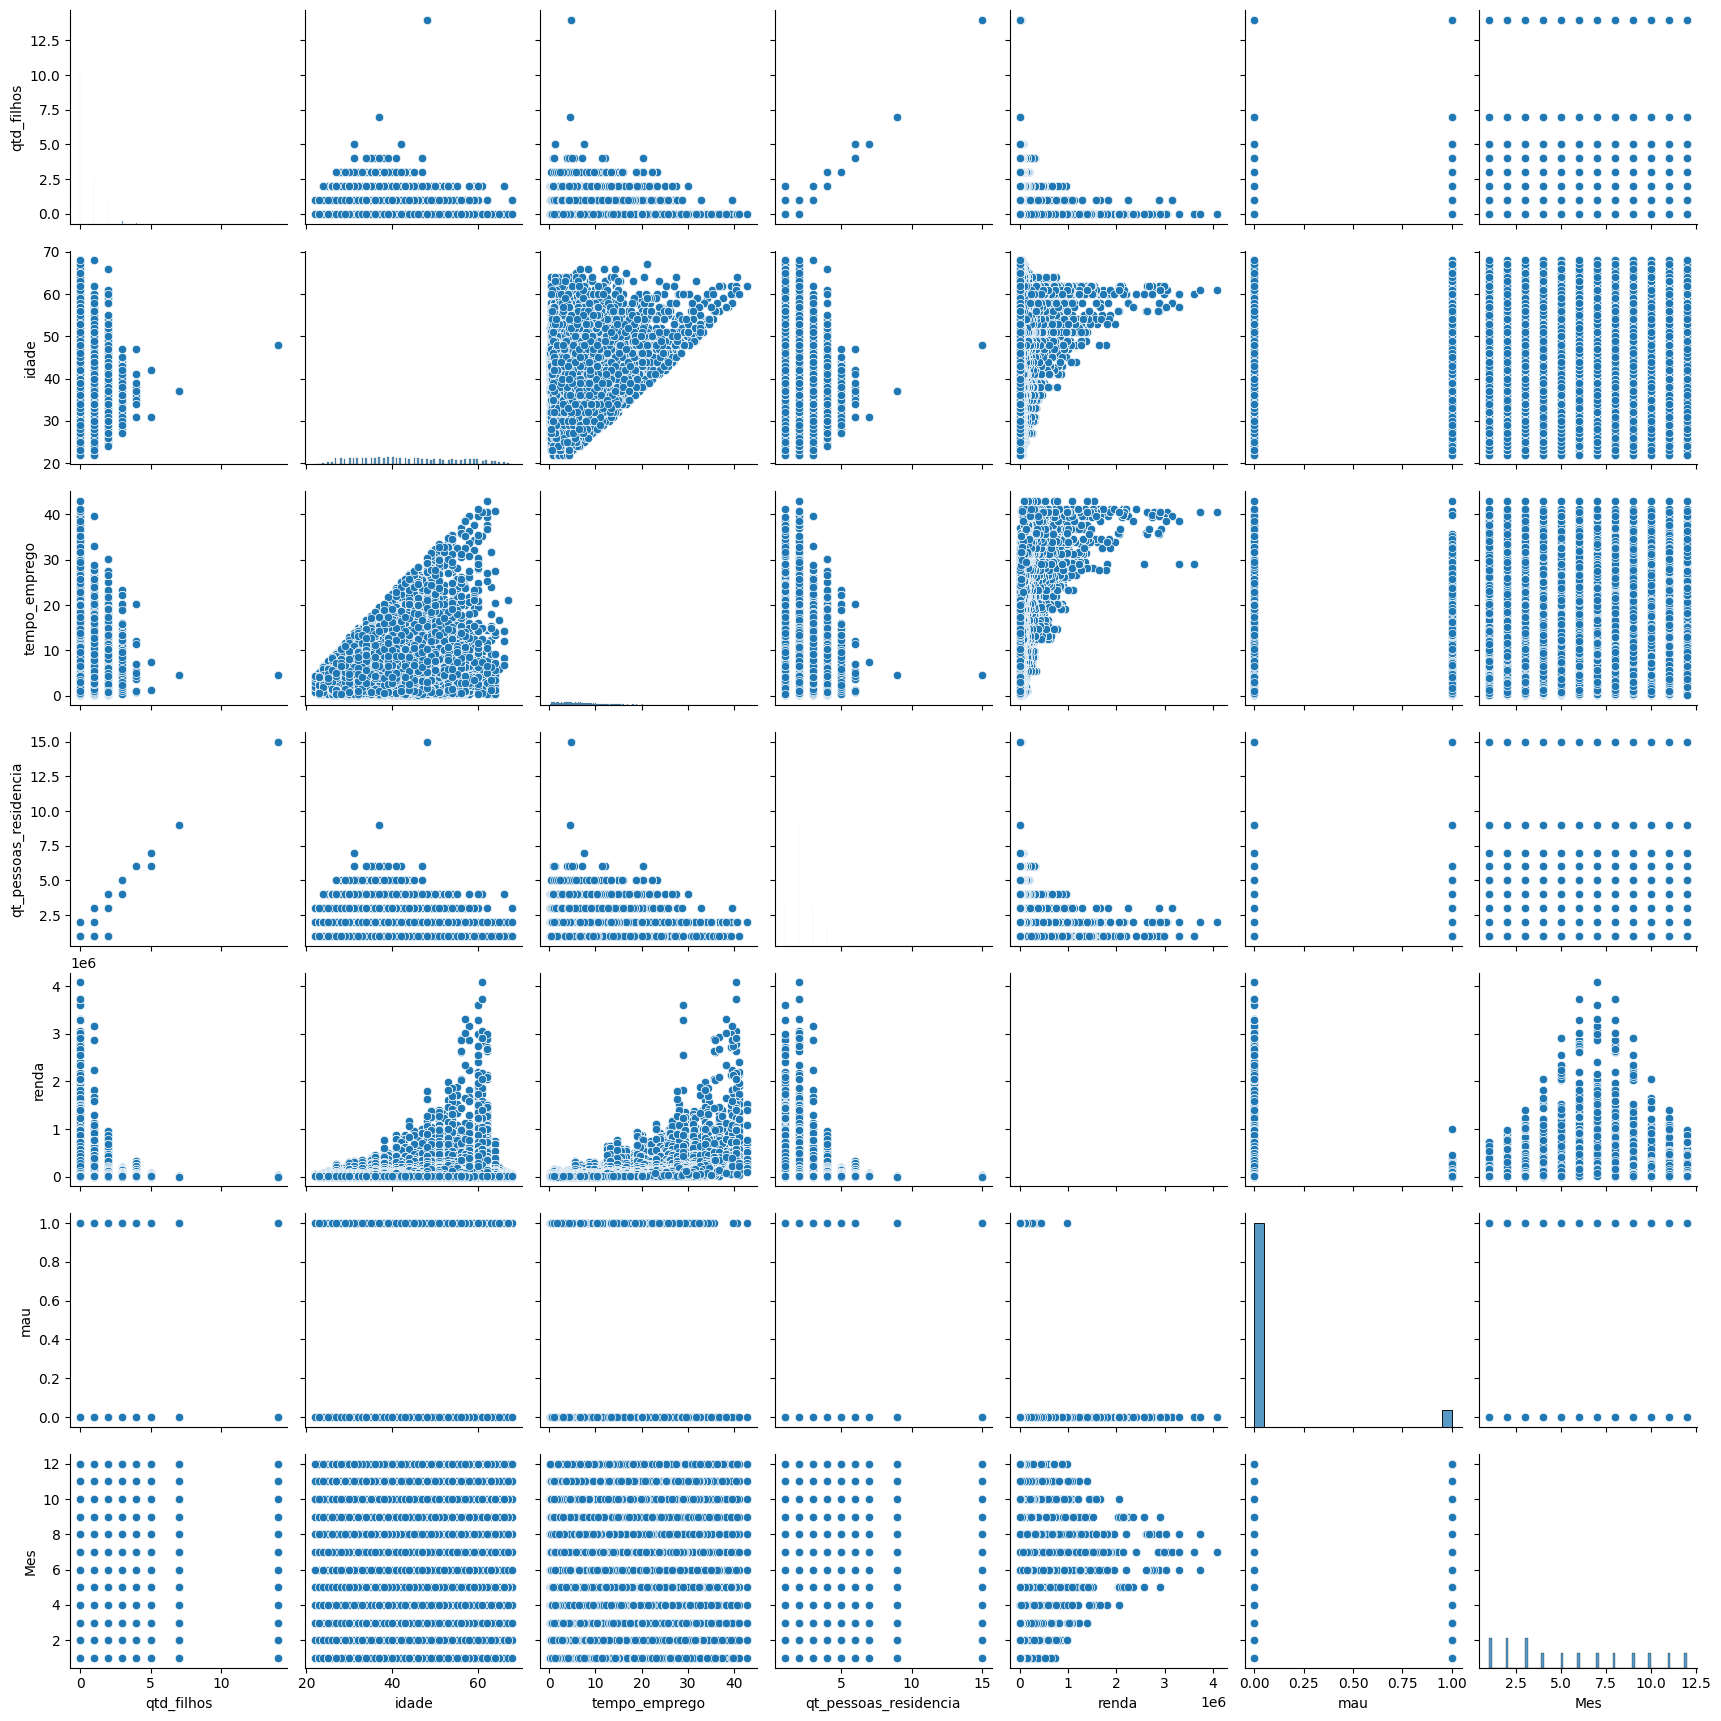

In [20]:
sns.pairplot(data=df[variaveis])

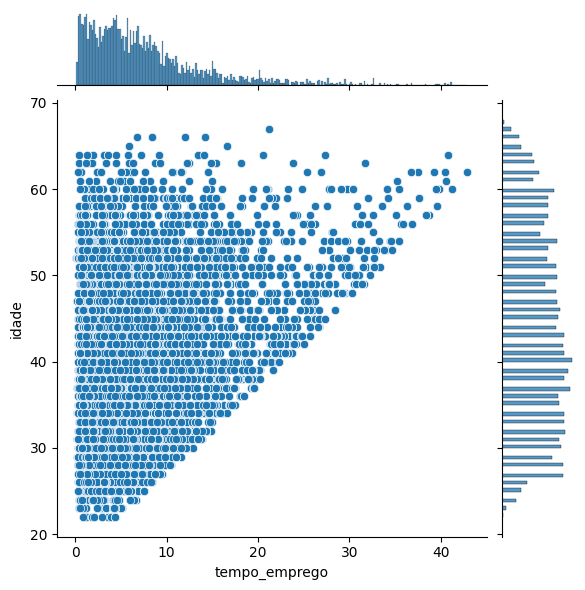

In [21]:
sns.jointplot(x="tempo_emprego", y="idade", data=df)

<font color=red> Uma analise com resultado ja esperado, a idade e o tempo de emprego sao diretamente proporcionais, assim pessoas mais velhas tendem a ter mais tempo de emprego.<font>

In [23]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[1]
    rótulo_nao_evento = tab.columns[0]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab

In [24]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,15,covariavel
index,int64,0,16650,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel


In [25]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)['iv_parcial'].sum()
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)['iv_parcial'].sum()

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,15,covariavel,0.345982
index,int64,0,16650,covariavel,0.002664
sexo,object,0,2,covariavel,0.002185
posse_de_veiculo,object,0,2,covariavel,0.000108
posse_de_imovel,object,0,2,covariavel,0.009693
qtd_filhos,int64,0,8,covariavel,0.000030
tipo_renda,object,0,5,covariavel,0.009360
educacao,object,0,5,covariavel,0.003547
estado_civil,object,0,5,covariavel,0.001126
tipo_residencia,object,0,6,covariavel,0.003045


In [26]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

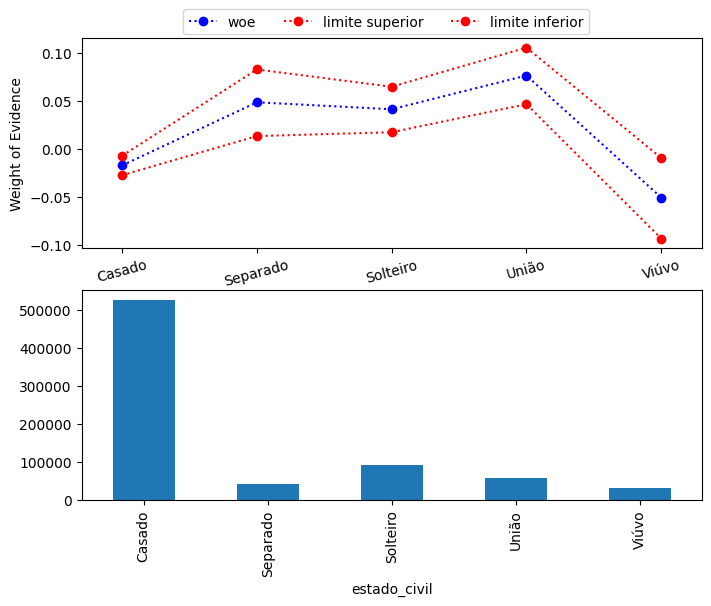

In [27]:
biv_discreta('estado_civil', df);

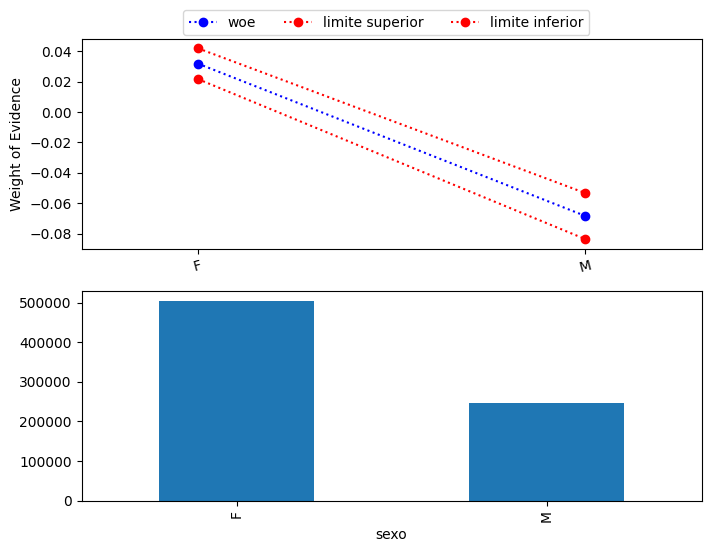

In [28]:
biv_discreta('sexo', df);

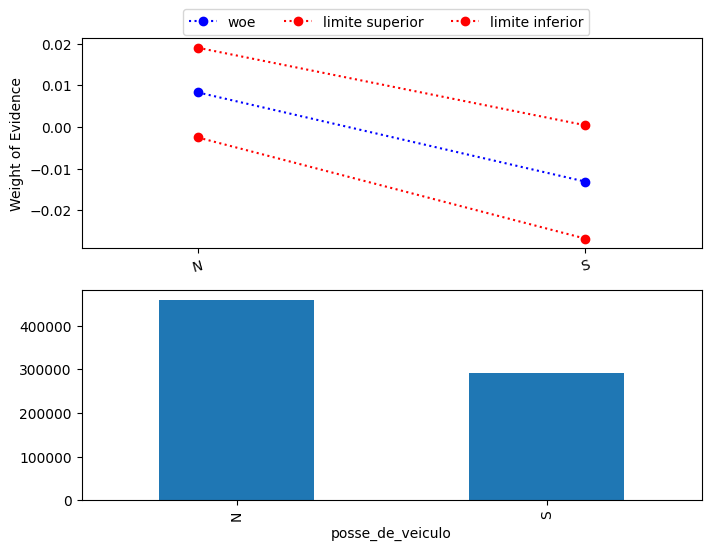

In [29]:
biv_discreta('posse_de_veiculo', df);

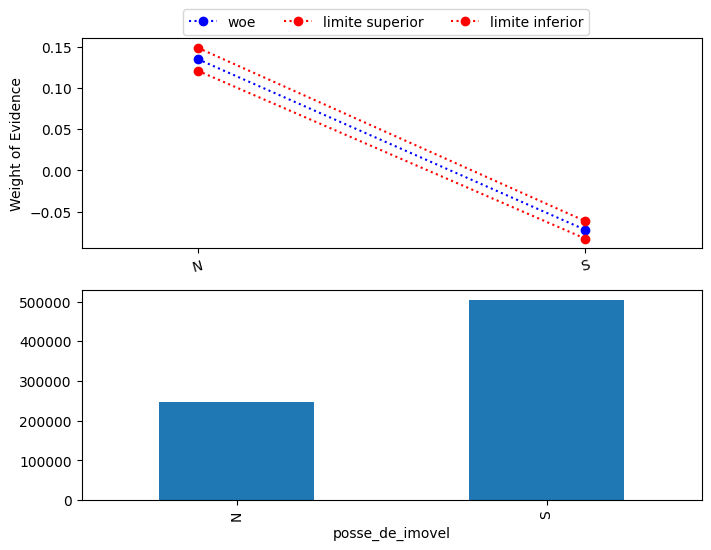

In [30]:
biv_discreta('posse_de_imovel', df);

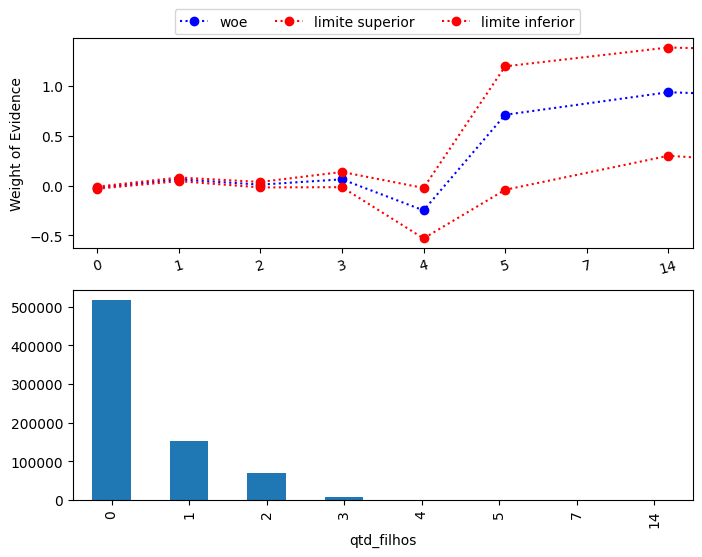

In [31]:
biv_discreta('qtd_filhos', df);

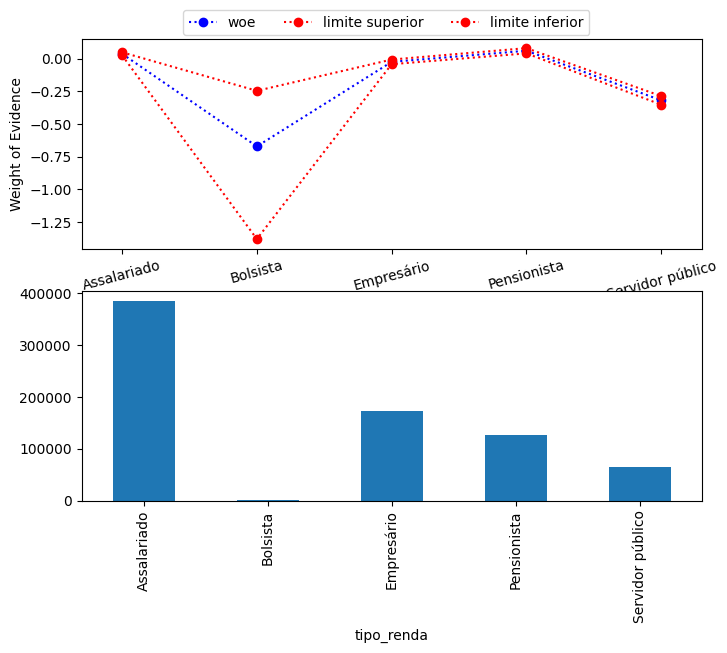

In [32]:
biv_discreta('tipo_renda', df);

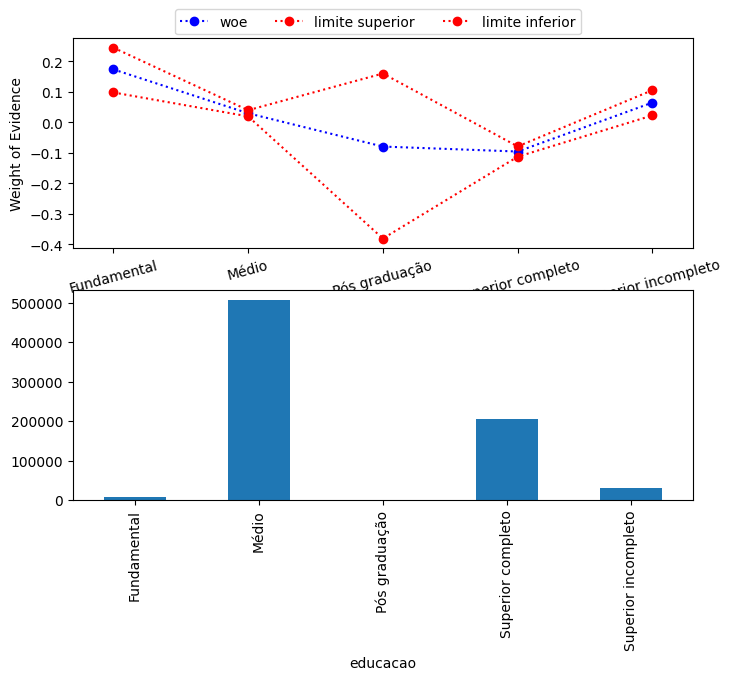

In [33]:
biv_discreta('educacao', df);

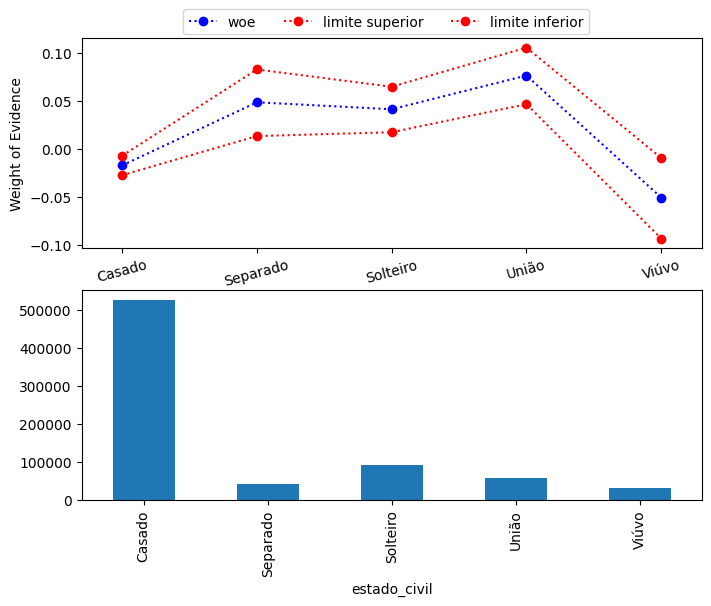

In [34]:
biv_discreta('estado_civil', df);

In [35]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

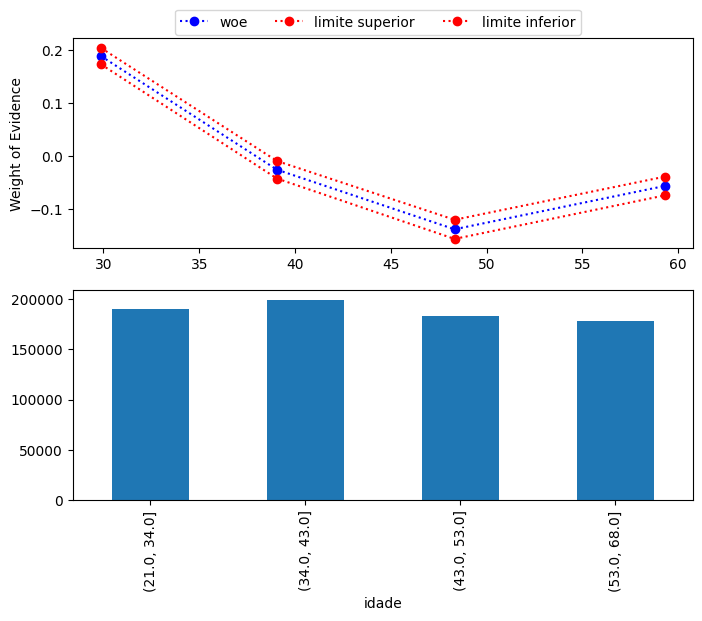

In [36]:
biv_continua('idade',4, df);

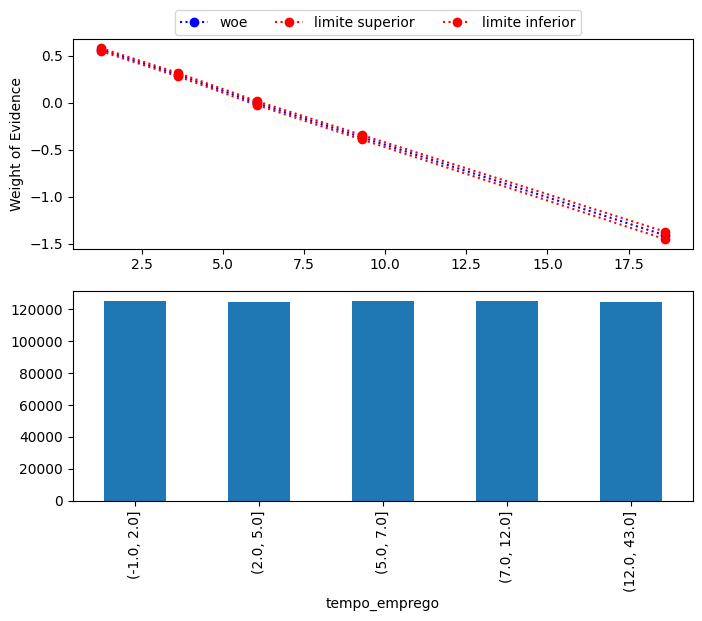

In [37]:
biv_continua('tempo_emprego',5, df);

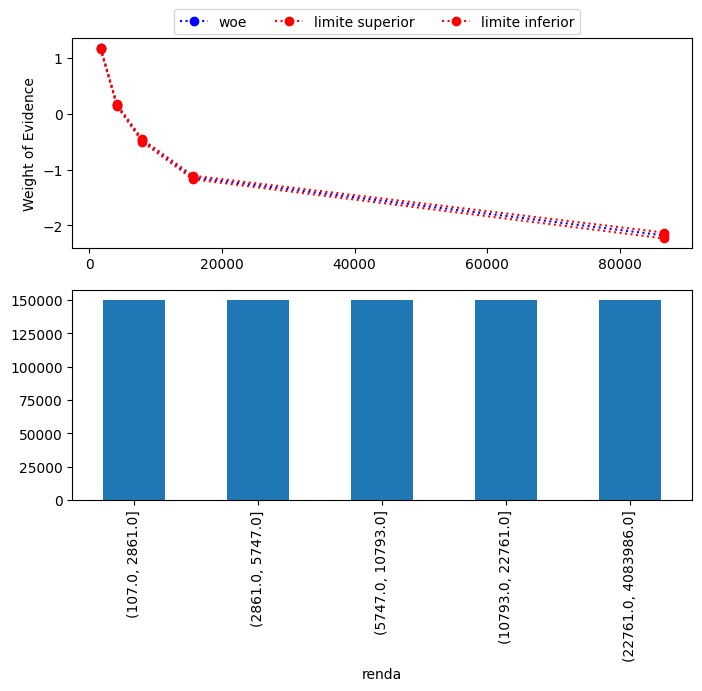

In [38]:
biv_continua('renda',5, df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [40]:
# Variáveis alvo e exclusão de variáveis irrelevantes
target = 'mau'
ignore_cols = ['data_ref', 'index']
features = [col for col in df1.columns if col not in ignore_cols + [target]]

In [41]:
# Tratar valores ausentes: substituir valores ausentes pela mediana (numéricas) ou moda (categóricas)
for col in features:
    if df1[col].dtype in ['float64', 'int64']:
        df1[col] = df1[col].fillna(df1[col].median())
    else:
        df1[col] = df1[col].fillna(df1[col].mode()[0])

In [42]:
# Tratar zeros estruturais: se alguma variável possui zeros "não reais", substituí-los por NaN e aplicar o tratamento adequado
zeros_estruturais = ['renda']  # Exemplo, ajustar conforme o dataset
for col in zeros_estruturais:
    df1[col] = df1[col].replace(0, np.nan).fillna(df1[col].median())

In [43]:
# Identificar e tratar outliers usando o intervalo interquartil (IQR)
for col in features:
    if df1[col].dtype in ['float64', 'int64']:
        q1 = df1[col].quantile(0.25)
        q3 = df1[col].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        df1[col] = np.clip(df1[col], lim_inf, lim_sup)

In [44]:
# Agrupar categorias pouco frequentes em uma única categoria "Outros"
categorias_a_ajustar = [col for col in features if df1[col].dtype == 'object']

for col in categorias_a_ajustar:
    freq = df1[col].value_counts(normalize=True)
    categorias_menos_frequentes = freq[freq < 0.05].index
    df[col] = df1[col].replace(categorias_menos_frequentes, 'Outros')

In [46]:
# Identificar os três últimos meses
ultimos_meses = df1['data_ref'].sort_values().unique()[-3:]

# Base de treino e OOT
df_oot = df1[df1['data_ref'].isin(ultimos_meses)]
desenv = df1[~df1['data_ref'].isin(ultimos_meses)]

# Separar X e y
X_train = desenv[features]
y_train = desenv[target]
X_oot = df_oot[features]
y_oot = df_oot[target]

In [49]:
# One-hot encoding para variáveis categóricas
X_train = pd.get_dummies(X_train, drop_first=True)
X_oot = pd.get_dummies(X_oot, drop_first=True)

# Garantir que as colunas de treino e OOT sejam consistentes
X_train, X_oot = X_train.align(X_oot, join='left', axis=1, fill_value=0)

# Treinar o modelo de regressão logística
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train, y_train)

# Coeficientes do modelo
coeficientes = pd.DataFrame({
    'Variável': X_train.columns,
    'Coeficiente': model.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)
print(coeficientes)

# Avaliação no conjunto OOT
y_pred = model.predict(X_oot)
y_proba = model.predict_proba(X_oot)[:, 1]

print("Relatório de Classificação:\n", print(classification_report(y_oot, y_pred, zero_division=0)))
print("AUC-ROC:", roc_auc_score(y_oot, y_proba))

                         Variável  Coeficiente
0                      qtd_filhos     0.245813
18             estado_civil_União     0.049284
6              posse_de_veiculo_S     0.028767
8             tipo_renda_Bolsista     0.004438
1                           idade     0.000142
4                           renda    -0.000121
13         educacao_Pós graduação    -0.007726
11    tipo_renda_Servidor público    -0.019111
2                   tempo_emprego    -0.019291
23        tipo_residencia_Estúdio    -0.026921
9           tipo_renda_Empresário    -0.046126
22    tipo_residencia_Comunitário    -0.070758
7               posse_de_imovel_S    -0.072347
10         tipo_renda_Pensionista    -0.083296
5                          sexo_M    -0.114542
12                 educacao_Médio    -0.139170
20           tipo_residencia_Casa    -0.144118
21    tipo_residencia_Com os pais    -0.145948
24  tipo_residencia_Governamental    -0.153853
14     educacao_Superior completo    -0.192553
15   educacao

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [56]:
# Previsões probabilísticas e classificações
y_pred_proba = model.predict_proba(X_oot)[:, 1]  # Probabilidades preditas
y_pred = model.predict(X_oot)  # Classificações binárias


# 1. Calcular Gini
auc = roc_auc_score(y_oot, y_pred_proba)
gini = 2 * auc - 1
print(f"AUC-ROC: {auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

# 2. Calcular KS
fpr, tpr, thresholds = roc_curve(y_oot, y_pred_proba)
ks = max(tpr - fpr)
print(f"KS Statistic: {ks:.4f}")

# 3. Calcular Acurácia
accuracy = accuracy_score(y_oot, y_pred)
print(f"Acurácia: {accuracy:.4f}")


AUC-ROC: 0.7270
Gini Coefficient: 0.4539
KS Statistic: 0.3342
Acurácia: 0.8533


# A - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer


In [1]:
def metadados(data, y):
    """
    Gera um resumo das características das variáveis em um DataFrame.

    Parâmetros:
    - data: pd.DataFrame - Conjunto de dados a ser analisado.
    - y: str - Nome da variável alvo (resposta).

    Retorna:
    - pd.DataFrame com informações sobre dtype, contagem, valores únicos, valores ausentes e papel (covariável ou resposta).
    """
    if y not in data.columns:
        raise ValueError(f"A variável de resposta '{y}' não está presente no DataFrame.")

    dframe = pd.DataFrame({
        'dtype': data.dtypes,
        'contagem': data.count(),
        'missing': data.isna().sum(),
        'nunique': data.nunique(),
        'papel': 'covariavel'
    })
    dframe.loc[dframe.index == y, 'papel'] = 'resposta'
    return dframe

def IV(variavel, resposta):
    """
    Calcula o Information Value (IV) para uma variável preditora em relação à resposta binária.

    Parâmetros:
    - variavel: pd.Series - Variável preditora.
    - resposta: pd.Series - Variável resposta binária.

    Retorna:
    - float - Valor do IV.
    """
    # Criar tabela cruzada
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    # Identificar rótulos de eventos e não-eventos
    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    
    tab['pct_evento'] = tab[rótulo_evento] / tab.loc['total', rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento] / tab.loc['total', rótulo_nao_evento]

    tab['woe'] = np.log(tab['pct_evento'] / tab['pct_nao_evento'])
    tab['iv_parcial'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['woe']

    # Retornar o IV total
    return tab['iv_parcial'].sum()

In [9]:
df = pd.read_feather('credit_scoring.ftr')
df.set_index(keys='data_ref', inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624043 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
 13  mau                    750000 non-null  bool   
dtypes: bool(1), float64(

In [13]:
metadados(df,'mau')

,dtype,contagem,missing,nunique,papel
index,int64,750000,0,16650,covariavel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [15]:
def trate_nulls(df):

    df.fillna(value=-1, inplace=True)

    return df

In [17]:
df = trate_nulls(df)
metadados(df,'mau')

,dtype,contagem,missing,nunique,papel
index,int64,750000,0,16650,covariavel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [26]:
def remove_outliers(df):

   outlier_factor = LocalOutlierFactor()

   # Detecta os outliers

   outliers = outlier_factor.fit_predict(df.select_dtypes(include='number'))

   # Filtra os dados mantendo apenas os não-outliers

   data = df[outliers != -1]

   return data

In [28]:
data = remove_outliers(df)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [31]:
dframe = metadados(data, y='mau')
dframe

,dtype,contagem,missing,nunique,papel
index,int64,735528,0,16650,covariavel
sexo,object,735528,0,2,covariavel
posse_de_veiculo,object,735528,0,2,covariavel
posse_de_imovel,object,735528,0,2,covariavel
qtd_filhos,int64,735528,0,8,covariavel
tipo_renda,object,735528,0,5,covariavel
educacao,object,735528,0,5,covariavel
estado_civil,object,735528,0,5,covariavel
tipo_residencia,object,735528,0,6,covariavel
idade,int64,735528,0,47,covariavel


In [33]:
for var in dframe[dframe.papel!='resposta'].index:
    if  (dframe.loc[var, 'nunique']>40):
        dframe.loc[var, 'IV'] = IV(pd.qcut(data[var],15,duplicates='drop'), data.mau)
    else: 
        dframe.loc[var, 'IV'] = IV(data[var], data.mau)
    
dframe.sort_values(by='IV', ascending=False, inplace=True)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [35]:
def pca(df, target, n_components=None):
    X = df.drop(columns=target)
    y = df[target]

    pca = PCA(n_components=n_components)

    pca.fit_transform(X.select_dtypes(include='number'))

    df = pd.DataFrame(pca.transform(X.select_dtypes(include='number')), index=X.index)

    df['mau'] = y

    return df

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [37]:
def dummies(df=None, columns=None):
    df = pd.get_dummies(df, drop_first=True, dtype='int', columns=columns)
    return df

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [39]:
pipe = Pipeline(steps=[('dummy', dummies(df, ['posse_de_veiculo'])),
                       ('missings', trate_nulls(df)),
                       ('outliers', remove_outliers(df)),
                       ('pca', pca(df, 'mau', 5))], )

# B - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [87]:
import pandas as pd
from pycaret.classification import *

In [88]:
df = pd.read_feather('./credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [89]:
df.shape

(750000, 15)

In [90]:
nds = df.sample(100000)

In [91]:
nds.drop(['data_ref','index'], axis=1, inplace=True)

In [92]:
data = nds.sample(frac=0.95, random_state=786)
data_unseen = nds.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (95000, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (5000, 13)


In [93]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [94]:
data.mau.value_counts(normalize=True)

mau
False    0.921274
True     0.078726
Name: proportion, dtype: float64

In [95]:
mod = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',remove_outliers = True,
                  fix_imbalance=True)


,Description,Value
0,Session id,184
1,Target,mau
2,Target type,Binary
3,Original data shape,"(95000, 13)"
4,Transformed data shape,"(144864, 30)"
5,Transformed train set shape,"(116364, 30)"
6,Transformed test set shape,"(28500, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.9%


In [96]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9215,0.7650,0.0631,0.5077,0.1122,0.0965,0.1584
1,0.9191,0.7898,0.0669,0.4118,0.1151,0.0952,0.1408
2,0.9209,0.7836,0.0688,0.4800,0.1204,0.1027,0.1592
3,0.9226,0.7727,0.0727,0.5588,0.1286,0.1125,0.1813
4,0.9202,0.7752,0.0459,0.4286,0.0829,0.0687,0.1198
5,0.9174,0.7763,0.0477,0.3333,0.0835,0.0650,0.1009
6,0.9205,0.7705,0.0630,0.4648,0.1109,0.0939,0.1488
7,0.9185,0.7641,0.0477,0.3676,0.0845,0.0676,0.1090
8,0.9218,0.7686,0.0573,0.5357,0.1034,0.0896,0.1563


In [97]:
tuned_lgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9227,0.7634,0.0803,0.5600,0.1405,0.1232,0.1910
1,0.9198,0.7873,0.0918,0.4528,0.1526,0.1295,0.1769
2,0.9192,0.7816,0.0688,0.4186,0.1182,0.0982,0.1446
3,0.9206,0.7642,0.0841,0.4731,0.1429,0.1220,0.1745
4,0.9232,0.7768,0.0746,0.5909,0.1324,0.1169,0.1905
5,0.9189,0.7701,0.0630,0.4074,0.1091,0.0899,0.1354
6,0.9198,0.7703,0.0706,0.4458,0.1219,0.1026,0.1531
7,0.9198,0.7649,0.0630,0.4400,0.1102,0.0923,0.1432
8,0.9217,0.7710,0.0668,0.5224,0.1184,0.1024,0.1661


Fitting 10 folds for each of 10 candidates, totalling 100 fits


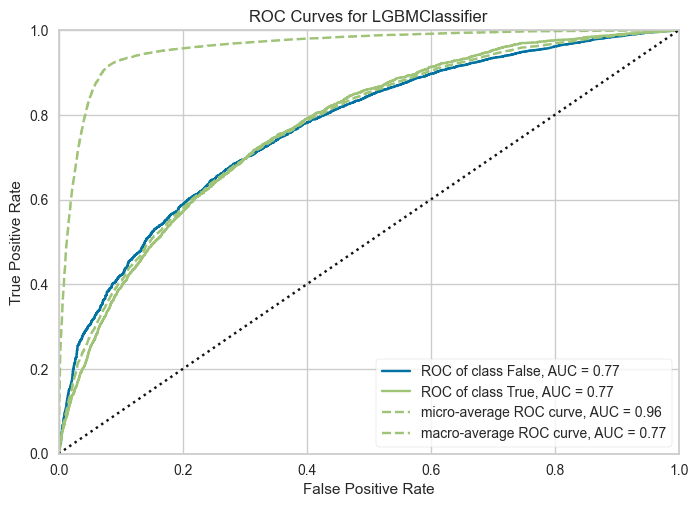

In [98]:
#plots
plot_model(tuned_lgbm, plot = 'auc')

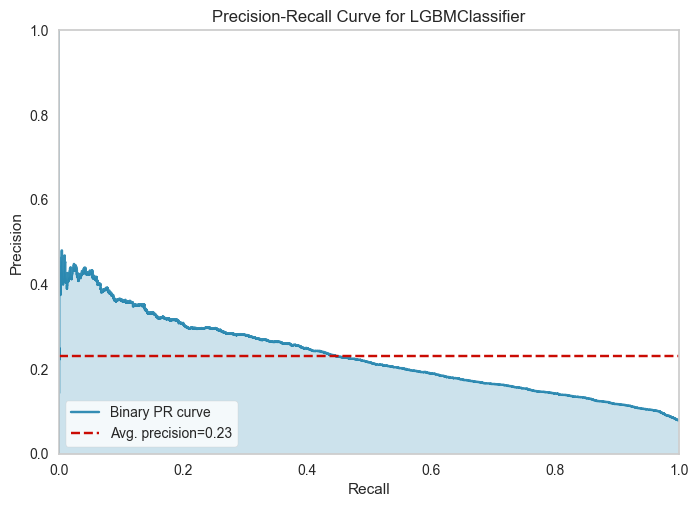

In [99]:
plot_model(tuned_lgbm, plot = 'pr')

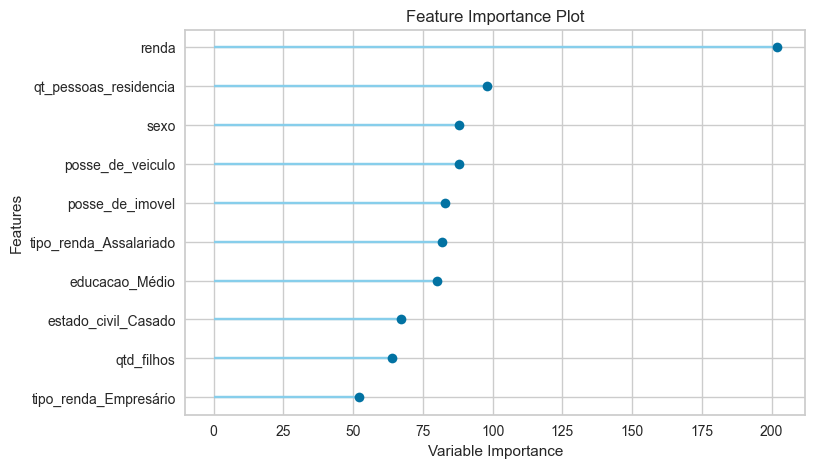

In [100]:
plot_model(tuned_lgbm, plot='feature')

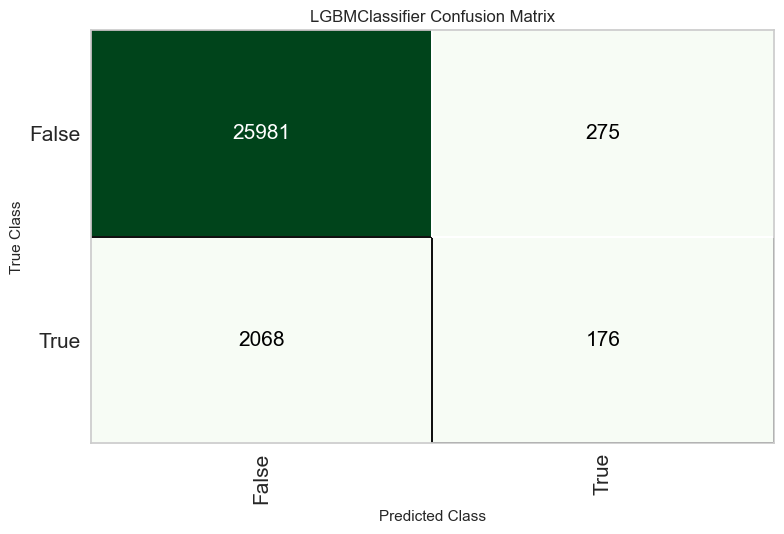

In [101]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

In [102]:
final_lgbm = finalize_model(tuned_lgbm)

In [103]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9186,0.7741,0.0753,0.4072,0.1271,0.1051,0.1483


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [104]:
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9274,0.7693,0.0644,0.4423,0.1125,0.0961,0.1477


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,S,3,Assalariado,Superior completo,Casado,Casa,41,0.334247,5.0,1798.030029,False,0,0.7427
1,M,S,S,1,Assalariado,Médio,Casado,Casa,36,4.693151,3.0,19583.910156,False,0,0.9532
2,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,42847.601562,False,0,0.9793
3,F,S,S,1,Assalariado,Médio,Casado,Casa,48,1.098630,3.0,2386.790039,True,0,0.7712
4,M,N,N,1,Empresário,Fundamental,Casado,Casa,29,6.802740,3.0,1565.719971,False,0,0.7669


In [105]:
#salvando e gerando o pipeline
save_model(final_lgbm,'Final LGBM Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            